## Project Overview

We made some predictions about how much bike rental traffic there will be in different areas of Chicago.

While there typically isn't too much traffic at individual stations, the influx and outflux of bikes to different service regions can have important logistic and business implications. Monitoring or, even better, predicting the movement of bikes around the city is useful!

This notebook mirrors the README but includes the associated code.

### Data Source

The Chicago Divvy bike share [data](https://divvy-tripdata.s3.amazonaws.com/index.html)
- 13 columns, ~2 million rows (1/2 year)

## The Data
Let's take a look at a single station first. The busiest station in Chicago in the past year was on Streeter Dr & Grand Ave.

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_funcs import *

In [2]:
sdga = station_data('Streeter Dr & Grand Ave', eda=True)

As a simple visualization, let's look at how much traffic there was at this one station on the last three days of our data set. Below are March 29-31st, a Monday to Wednesday, where you can see traffic peaked in the afternoon but was much lower on Wednesday.

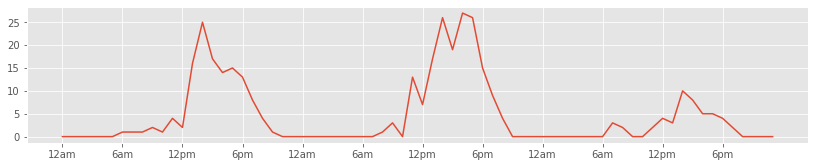

In [24]:
fig, ax = plt.subplots(figsize=(14,2.5))

ax.plot(np.arange(72), sdga['target'].iloc[-72:])
ax.set_xticks([0,6,12,18,24,30,36,42,48,54,60,66])
ax.set_xticklabels(['12am','6am','12pm','6pm','12am','6am','12pm','6pm','12am','6am','12pm','6pm']);

Next we'll look at how all of the downtown stations looked, with the Streeter and Grand station included. The graph below is almost the same but instead of all traffic, this one is broken down into riders entering downtown and riders leaving downtown. Trips that began and ended within downtown are not included.

We can see some pretty regular trends: a 9am spike, a bit of activity for lunch, and then a 5pm spike. This is pretty likely to be commuters and if you were to look at some weekend data it's a bit more spread out.

Interestingly about the same amount of riders come into downtown at the beginning and end of the day, but riders leaving downtown are pretty concentrated in the evening.

In [13]:
dt_s = station_data('downtown', start_end='start', exclude_within_region=True)
dt_e = station_data('downtown', start_end='end', exclude_within_region=True)

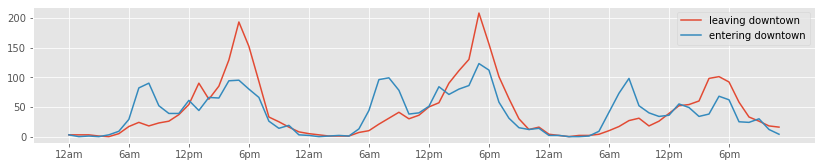

In [3]:
fig, ax = plt.subplots(figsize=(14,2.5))

ax.plot(np.arange(72), dt_s['target'].iloc[-72:], label='leaving downtown')
ax.plot(np.arange(72), dt_e['target'].iloc[-72:], label='entering downtown')
ax.set_xticks([0,6,12,18,24,30,36,42,48,54,60,66])
ax.set_xticklabels(['12am','6am','12pm','6pm','12am','6am','12pm','6pm','12am','6am','12pm','6pm'])
ax.legend();

And in fact you can compare bikes coming in and out not just on the hour, but over time. Over the past year there's been 18,000 more rides going out than coming in. If bikes are not transported back, they would quickly disappear from downtown.

In [4]:
# How many more bikes are leaving downtown than coming in?
(dt_s.sum() - dt_e.sum())[0]

18199.0

So it's not hard to see how the flow of bikes between areas is an important logistical problem. Getting ahead of the curve before stations start running out of bikes can be the difference between losing loyal customers and keeping commuters happy.

## Predicting Traffic
The simplest prediction is just that for any given hour the amount of bikes entering and leaving an area will be the annual average.

In [8]:
print('Average bikes entering downtown per hour: {}'.format(int(dt_s.mean()[0])))
print('Average bikes leaving downtown per hour: {}'.format(int(dt_e.mean()[0])))

Average bikes entering downtown per hour: 47
Average bikes leaving downtown per hour: 45


But we can certainly build a better model than this. There are plenty of options for making predictions. Another simple prediction is to just guess that traffic will look the same as the day before, hour for hour. The problem here is that traffic isn't only dependent on time, but changes day to day. An ARIMA model is a popular choice that takes into account general trends (many bikeshare programs are expanding!) but has a difficult time with more than one trend pattern at play (known as multi-seasonality). Traffic depends not only on time, but day of the week, month, holidays, etc. which are totally on their own timelines and are therefor difficult to capture with ARIMA and time series analysis.

Recurrent neural networks are models that can be trained on several months of data and but also have a short term memory that takes into account the most recent information when making predictions. LSTMs (long short term memory) and GRUs (gated recurrent unit) are improved versions that make the most of the memory they have. Let's make a GRU model that can predict what traffic will look like in the next few hours.

In [ ]:
# Model that learns from rides leaving downtown, predicts how many will leave in the future
gru_downtown_out = Model(dt_s)

In [ ]:
# Train the model. 
# Training 2 or 3 times can improve model performance but will eventually get worse as the model overfits.
gru_downtown_out.train()

In [ ]:
# Save the model to use later
gru_downtown_out.model.save('models/my_model')

In [3]:
# We can also load up models we saved before
old_model = tf.keras.models.load_model('models/downtown_in')
gru_downtown_in = Model(df=dt_e, load_model=old_model)

These models were all trained on data from October 2020 until March 2021. During this training the model learning how to take a look at a five day window in the past and predict up to five days into the future. Let's make a simple prediction.

Below the model looks at March 25-29 and makes a prediction for March 30th. In this case it doesn't do a bad job, and improves significantly over the baseline of just guessing the baseline.

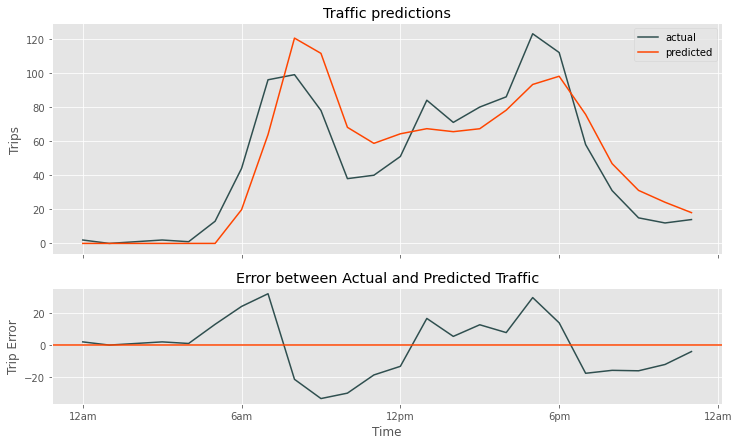

In [4]:
gru_downtown_in.predict_plot(n_out=24, offset=72)

In [5]:
# These prediction scores use RMSE
# Here the baseline is calculated as the average traffic of the previous 24 hours
yhat, ybase = gru_downtown_in.predict_score(n_out=24, offset=72)

print('This model did {}% better than baseline'.format(round((1-yhat/ybase)*100, 2)))

This model did 60.7% better than baseline


This model is not immune to some of the difficulties other models face. For example if we look at five weekdays and then predict a Saturday, the model does a good job of repeating what it remembers but faces an unexpected reality.

Below is a prediction of March 27th, a Saturday, looking at March 22-26, a Monday to Friday. Turns out people don't ride the same way on Saturdays.

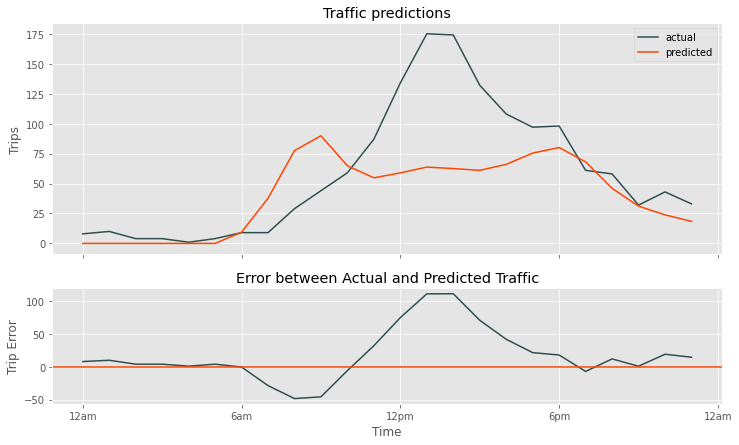

In [6]:
gru_downtown_in.predict_plot(n_out=24, offset=0)

In [7]:
# Score of the above graph
yhat, ybase = gru_downtown_in.predict_score(n_out=24, offset=0)

print('This model did {}% better than baseline'.format(round((1-yhat/ybase)*100, 2)))

This model did 26.92% better than baseline


It is possible to make a model that looks back farther than five days. But as they say in the math and data science world, there's no free lunch. A longer memory will require more complicated neural network architecture to capture trends and that will in turn require much more processing power.

But for our purposes this model is enough. It doesn't require an inordinate amount of time to train and can look decently enough six to twelve hours into the future.

Here's a hypothetical use case:

In [14]:
# Grabbing the "traffic out" downtown model
old_model = tf.keras.models.load_model('models/downtown_out')
gru_downtown_out = Model(df=dt_s, load_model=old_model)

In [17]:
# Making 6 hour predictions from both traffic in and traffic out models
pred_in = gru_downtown_in.predict(n_out=12, offset=54)
pred_in = gru_downtown_in.scaler.inverse_transform(pred_in.reshape(-1, 1))

pred_out = gru_downtown_out.predict(n_out=12, offset=54)
pred_out = gru_downtown_out.scaler.inverse_transform(pred_out.reshape(-1, 1))

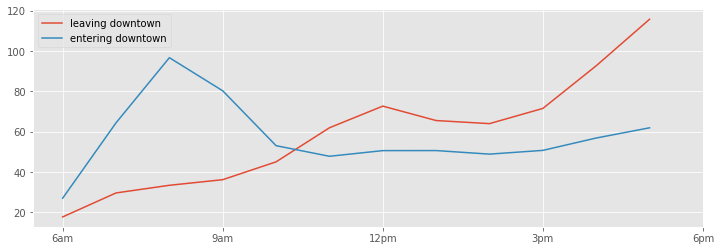

In [18]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(np.arange(12), pred_out, label='leaving downtown')
ax.plot(np.arange(12), pred_in, label='entering downtown')
ax.set_xticks([0,3,6,9,12])
ax.set_xticklabels(['6am','9am','12pm','3pm','6pm'])
ax.legend();

This graph is purely a prediction. It looks at the past to figure out what traffic in and traffic out will look like for downtown on specifically Monday March 29th from 6am to 6pm. With data collected over the previous five days, it could be run automatically in less than an hour and sent to somebody's dashboard.

With a little more domain knowledge this becomes pretty useful. The average 8am in-bound spike over the previous 6 months was about 80 rides, meaning this morning might be busy. The average 5pm out-bound spike was almost 150, meaning this evening might be slow.

### Assumptions

- The past year has been something of an anomoly with the pandemic and all. Can we draw meaningful conclusions from all this that wouldn't just fade away as vaccines roll out and business returns to normal? The numbers [seem to say](https://github.com/nick-kopy/Exploration-of-bike-share-programs-post-pandemic) that even though Chicago's bikeshare program did take a hit initially, it bounced back pretty quick. So assuming that these conclunsions and predictions are still relevant in the era of COVID seems to be upheld.
- Station groupings are loosely based on [this map](https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations-All-Map/bk89-9dk7) by on the Chicago Data Portal. These are not official groupings of any kind and are actually not restricted to their labels, meaning some Wicker Park stations are actually in West Town for example but Wicker Park was just an easy name to label that "glob" on the map. These models would really benefit (and be more applicable to the business) with relevant and sensical groupings.

## production

In [ ]:
# try to predict different time periods with model (wtf)

In [8]:
keras_obj = tf.keras.models.load_model('models/chinatown_end')
ct_data = station_data('chinatown', start_end='end')
model = Model(df=ct_data, model=keras_obj)

In [12]:
model.X_test[0]

array([[ 2.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 3.],
       [ 6.],
       [10.],
       [ 6.],
       [ 9.],
       [12.],
       [25.],
       [26.],
       [12.],
       [33.],
       [18.],
       [43.],
       [46.],
       [40.],
       [25.],
       [13.],
       [ 4.],
       [ 3.],
       [ 5.],
       [ 0.],
       [ 4.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 2.],
       [ 6.],
       [ 7.],
       [13.],
       [10.],
       [10.],
       [15.],
       [11.],
       [ 7.],
       [ 9.],
       [ 8.],
       [11.],
       [ 8.],
       [ 8.],
       [ 4.],
       [ 1.],
       [ 3.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [10.],
       [ 9.],
       [ 9.],
       [11.],
       [12.],
       [ 6.],
       [12.],
       [11.],
       [11.],
       [20.],
       [22.],
       [29.],
       [16.],
       [10.],
       [ 4.],
       [ 6.],
      

In [19]:
dt_s['hour'] = np.tile(np.arange(24), 365)
dt_e['hour'] = np.tile(np.arange(24), 365)

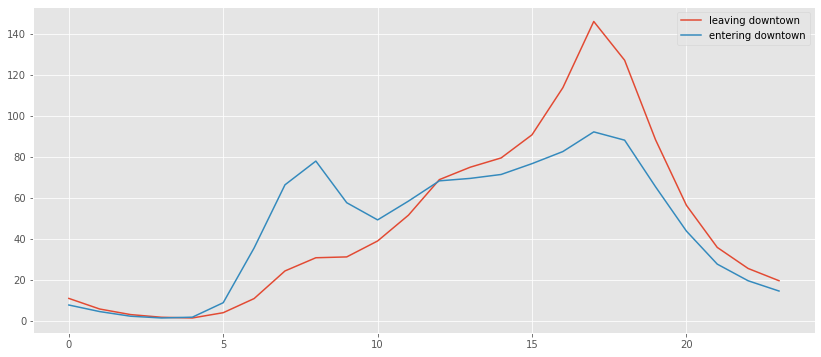

In [22]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(np.arange(24), dt_s.groupby('hour').agg('mean'), label='leaving downtown')
ax.plot(np.arange(24), dt_e.groupby('hour').agg('mean'), label='entering downtown')
ax.legend();

In [18]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

# # load dataset
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# # configure
# n_lag = 1
# n_seq = 3
# n_test = 10
# n_epochs = 1500
# n_batch = 1
# n_neurons = 1
# # prepare data
# scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# # fit model
# model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# # make forecasts
# forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# # inverse transform forecasts and test
# forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
# actual = [row[n_lag:] for row in test]
# actual = inverse_transform(series, actual, scaler, n_test+2)
# # evaluate forecasts
# evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# # plot forecasts
# plot_forecasts(series, forecasts, n_test+2)

<ipython-input-18-fef4008c63b5>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [19]:
series = dt_s.copy()

n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 15
n_batch = 1
n_neurons = 32

In [20]:
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [21]:
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

8746/8746 [==============================] - 13s 2ms/step - loss: 0.0095


In [22]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)

actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

In [24]:
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 18.619626
t+2 RMSE: 33.265158
t+3 RMSE: 45.096011


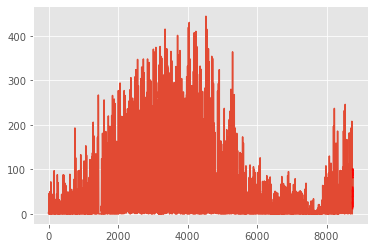

In [23]:
plot_forecasts(series, forecasts, n_test+2)